# NOTE
No single approach is known to work universally on all kinds of data and all the classification problems.
Dataset used: Figure eight - Economic news article tone and relevance


# STEP- Loading the dataset and using the necessary imports

In [1]:
# Naive Bayes Classifier is a probabilistic classifier that uses bayes theorem to classify texts based on the eveidence 
#seen in training data.

import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#to use feature extraction methods scikit library is to be used
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#to preprocess the text
import string
import re  #this is for using regular expressions

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

/Users/hritiksethi/opt/anaconda3/envs/virtual_environment_name/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv

--2020-12-30 12:42:05--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com... 151.101.36.133
Connecting to raw.githubusercontent.com|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: 'DATAPATH/Full-Economic-News-DFE-839861.csv'

Full-Economic-News- 100%[===================>]  11.81M  8.07MB/s    in 1.5s    

2020-12-30 12:42:07 (8.07 MB/s) - 'DATAPATH/Full-Economic-News-DFE-839861.csv' saved [12383529/12383529]



In [3]:
!ls -lah DATAPATH

total 24552
drwxr-xr-x@ 3 hritiksethi  staff    96B Dec 30 12:42 .
drwxr-xr-x@ 5 hritiksethi  staff   160B Dec 30 12:42 ..
-rw-r--r--  1 hritiksethi  staff    12M Dec 30 12:42 Full-Economic-News-DFE-839861.csv


In [4]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

display(our_data.shape) #Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] #Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [10]:
print(our_data)

       _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0     842613455    False   finalized                   3     12/5/15 17:48   
1     842613456    False   finalized                   3     12/5/15 16:54   
2     842613457    False   finalized                   3      12/5/15 1:59   
3     842613458    False   finalized                   3      12/5/15 2:19   
4     842613459    False   finalized                   3     12/5/15 17:48   
...         ...      ...         ...                 ...               ...   
7995  830985632    False   finalized                   3    11/17/15 18:16   
7996  830985633    False   finalized                   3     11/18/15 8:10   
7997  830985634    False   finalized                   3    11/18/15 12:12   
7998  830985635    False   finalized                   3     11/18/15 7:17   
7999  830985636    False   finalized                   3    11/18/15 11:05   

      positivity  positivity:confidence relevance  relevance:co

# There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [11]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] #Let us take only the two columns we need.
our_data.shape

<ipython-input-11-471e8fa30727>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0.


(7991, 2)

In [27]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ") #This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    #remove punctuation and numbers
    return doc

In [28]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#Step 1: train-test split
X = our_data.text #the column text contains textual data to extract features from
y = our_data.relevance #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [29]:
#Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#use it to extract features from training data
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!


(5993, 49753) (1998, 49753)


In [17]:
#Step 3: Train the classifier and predict for test data
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm

CPU times: user 7.68 ms, sys: 2.18 ms, total: 9.85 ms
Wall time: 8.65 ms


Accuracy:  0.7527527527527528
ROC_AOC_Score:  0.7208538152950815


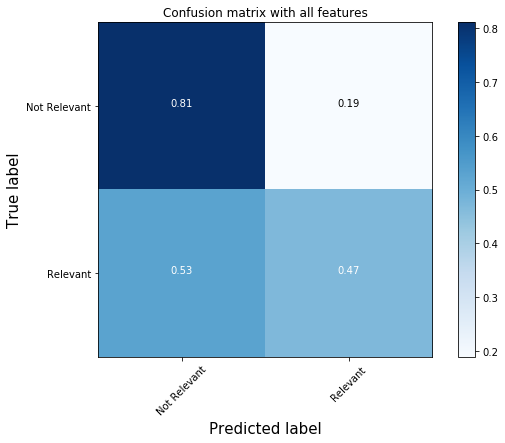

In [18]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))


At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

CPU times: user 3.8 ms, sys: 418 µs, total: 4.21 ms
Wall time: 4.25 ms
Accuracy:  0.6791791791791791


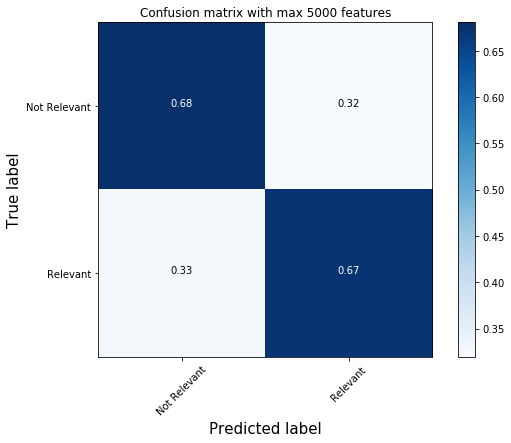

In [20]:
vect = CountVectorizer(max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

Accuracy:  0.7442442442442443
AUC:  0.7208538152950815


/Users/hritiksethi/opt/anaconda3/envs/virtual_environment_name/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


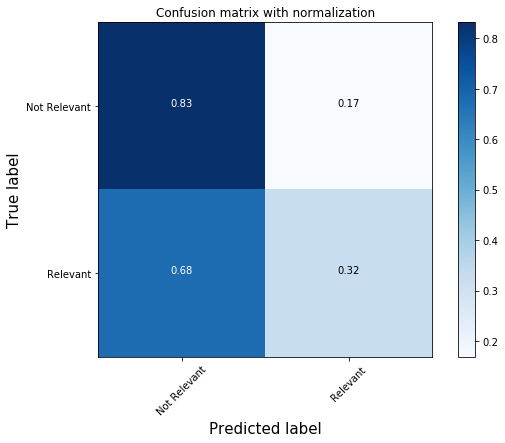

In [21]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a linear svc model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

Accuracy:  0.5900900900900901
AUC:  0.7208538152950815


/Users/hritiksethi/opt/anaconda3/envs/virtual_environment_name/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


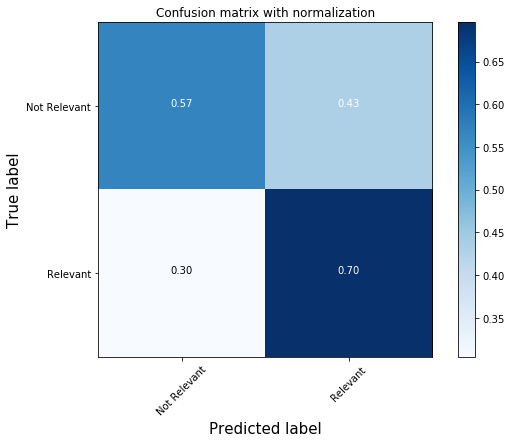

In [26]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')


So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase!